# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Условия задачи:</b>

1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

#### Описание данных: 

Данные геологоразведки трёх регионов находятся в файлах:
1. geo_data_0.csv. Скачать датасет
2. geo_data_1.csv. Скачать датасет
3. geo_data_2.csv. Скачать датасет
4. id — уникальный идентификатор скважины;
5. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
6. product — объём запасов в скважине (тыс. баррелей).

# Содержание

<ul>
    <li>
        <a href='#section0'>1. Загрузка и подготовка данных</a>
        <ul>
            <li>
                <a href='#section1'>1.1 Импорт библиотек</a>
            </li>
            <li>
                <a href='#section2'>1.2 Чтение файлов и изучение данных</a>
            </li>
            <li>
                <a href='#section3'>1.3 Проверка на наличие дубликатов</a>
            </li>
             <li>
                <a href='#section4'>1.4 Корелляция</a>
            </li>
            <li>
                <a href='#section5'> Выводы</a>
            </li>
</ul>
</li>
    <li>
        <a href='#section6'>2. Обучение и проверка модели</a>
        <ul>
         <li>
                <a href='#section7'>2.1 Обучение и проверка модели для первого региона</a>
          </li>
         <li>
                <a href='#section8'>2.2 Обучение и проверка модели для второго региона</a>
          </li>  
            <li>
                <a href='#section9'>2.3  Обучение и проверка модели для третьего региона</a>
          </li> 
             <li>
                <a href='#section10'> Выводы</a>
          </li> 
            </ul>
 <li>
   <a href='#section11'>3. Подготовка к расчёту прибыли</a>
</li>
<li>
        <a href='#section12'>4. Расчёт прибыли и рисков</a>
     <ul>
         <li>
                <a href='#section13'>4.1 Бутстрап: Регион 1</a>
          </li>
          <li>
                <a href='#section14'>4.2 Бутстрап: Регион 2</a>
          </li>
         <li>
                <a href='#section15'>4.3 Бутстрап: Регион 4</a>
          </li>
          <li>
                <a href='#section16'>Выводы</a>
          </li>
    </ul>
<li>
        <a href='#section17'>5. Общий вывод</a>
    </li>
</ul>

# 1. Загрузка и подготовка данных
<a id='section0'></a>

### 1.1. Импорт библиотек
<a id='section1'></a>

In [1]:
import os
import urllib.request
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score 
from numpy.random import RandomState
state = RandomState(12345)

### 1.2. Чтение файлов и изучение данных
<a id='section2'></a>

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

Выведем первые 5 строк каждого датасета

In [3]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Изучим датасеты методом info и describe

In [4]:
print('\n\n-------------------------Первый Датасет---------------------------------\n\n')
display(geo_data_0.info())
display(geo_data_0.describe())
print('\n\n-------------------------Второй Датасет---------------------------------\n\n')
display(geo_data_1.info())
display(geo_data_1.describe())
print('\n\n-------------------------Третий Датасет---------------------------------\n\n')
display(geo_data_2.info())
display(geo_data_2.describe())



-------------------------Первый Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




-------------------------Второй Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




-------------------------Третий Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### 1.3 Проверка на наличие дубликатов 
<a id='section3'></a>

In [5]:
print('Датасет №0, количество дубликатов: ',geo_data_0.duplicated().sum())
print('Датасет №1, количество дубликатов: ',geo_data_1.duplicated().sum())
print('Датасет №2, количество дубликатов: ',geo_data_2.duplicated().sum())

Датасет №0, количество дубликатов:  0
Датасет №1, количество дубликатов:  0
Датасет №2, количество дубликатов:  0


Уникальные значения таблиц

In [6]:
display(geo_data_0.nunique())
display(geo_data_1.nunique())
display(geo_data_2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

### 1.4 Корелляция 
<a id='section4'></a>

Оценка корреляций признаков

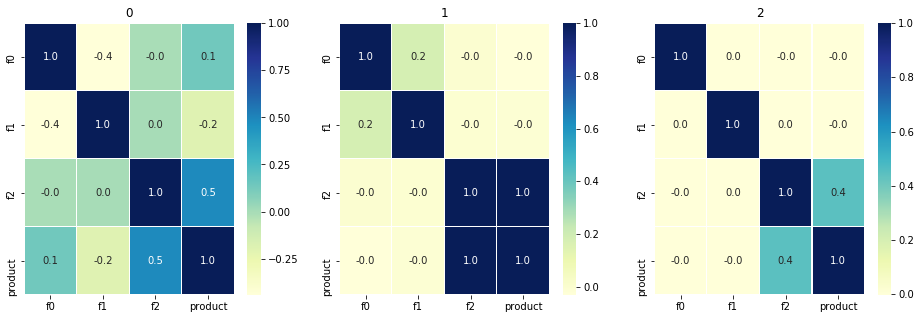

In [7]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i,j in zip([geo_data_0,geo_data_1,geo_data_2],range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j], cmap="YlGnBu")
    ax[j].set_title(str(j))

In [8]:
display(geo_data_0.corr())
display(geo_data_1.corr())
display(geo_data_2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


## Выводы

1. Все датасеты хорошо подготовлены, все типы данных указаны правильно, дубликатов не имеется. В каждом по 100 000 наблюдений.
2. Признак F2 очень сильно коррелирует с product
3. Имеются повторяющиеся значения в столбцах ID, видимо пробы брались несколько раз в одной и той же скважине.
4. У второго датасета уникальных значений в product всего 12. Наша будущая модель может слишком хорошо прогнозировать. 

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка данных и их анализ сделан хорошо.
</div>

# 2. Обучение и проверка модели
<a id='section5'></a>

Создадим листы для хранения результатов прогнозирования и их метрик.
Через цикл проверим модели на всех трех датасетах и сохраним результаты метрик и прогнозирований в наши листы.

In [9]:
rmse_list = []
predictions_list = []
score_list = []
target = []
predictions_df = pd.DataFrame()
target_df = pd.DataFrame()

for i,j in zip([geo_data_0,geo_data_1,geo_data_2],range(3)):
    X = i.drop(['product','id'], axis=1)
    y = i['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=12345, test_size=0.25) 
    
    lr = LinearRegression(n_jobs = -1)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_valid)
    rmse = np.sqrt(np.mean((y_valid-predictions)**2))
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(lr.score(X_train,y_train))
    target.append(i['product'].mean())
    target_df[j] = y_valid
    predictions_df[j] = predictions

Создадим таблицу с имеющимися листами, чтобы сравнить результаты

In [43]:
target_df = target_df.reset_index(drop=True)
scorelist = pd.DataFrame(
    data=[rmse_list, score_list, predictions_list, target], 
    index=['RMSE','SCORE','PREDICTED MEAN', 'TARGET MEAN'], 
    columns=['geo_data_0','geo_data_1','geo_data_2'])
scorelist

,geo_data_0,geo_data_1,geo_data_2
RMSE,37.579422,0.893099,40.029709
SCORE,0.274239,0.999625,0.196614
PREDICTED MEAN,92.592568,68.728547,94.965046
TARGET MEAN,92.500000,68.825000,95.000000


## Вывод

Очевидно, что среднее спрогнозированное и среднее target почти похоже.
Посмотрим на результаты которые мы получили у моделей:

<table width="400">
    <tbody><tr>
<td></td>
        <td>RMSE</td>
        <td>SCORE</td>
    </tr>
    <tr>
<td>Регион №1</td>
        <td>37.5</td>
        <td>0.27</td>
    </tr>
    <tr>
<td>Регион №2</td>
        <td>0.89</td>
        <td>0.99</td>
    </tr>
    <tr>
<td>Регион №3</td>
        <td>40.02</td>
        <td>0.19</td>
    </tr>
</tbody></table>

Модели первого региона и третьего показывают очень плохие результаты. Не стоит использовать их для выбора скважины в регионе.

Модель второго региона показыла очень хорошие результаты, но как мы и предвидели из-за того что у цели всего лишь 12 значений из 100 000 для модели было легко спрогнозировать правильные ответ. поэтому вторую модель также опасно использовать.

Предсказанное среднее и target среднее почти одинаково

<table width="400">
    <tbody><tr>
<td></td>
        <td>Predicted mean</td>
        <td>Target mean</td>
    </tr>
    <tr>
<td>Регион №1</td>
        <td>92.59</td>
        <td>92.50</td>
    </tr>
    <tr>
<td>Регион №2</td>
        <td>68.72</td>
        <td>68.82</td>
    </tr>
    <tr>
<td>Регион №3</td>
        <td>94.96</td>
        <td>95.00</td>
    </tr>
</tbody></table>

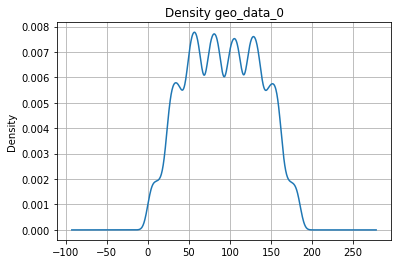

In [20]:
density_1 = geo_data_0['product'].plot(kind = 'density', label = True, title = 'Density geo_data_0', grid =  True)
plt.show()

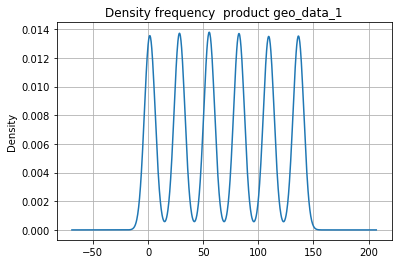

In [24]:
density_2 =geo_data_1['product'].plot(kind = 'density', grid = True, title = 'Density frequency  product geo_data_1')
plt.show()

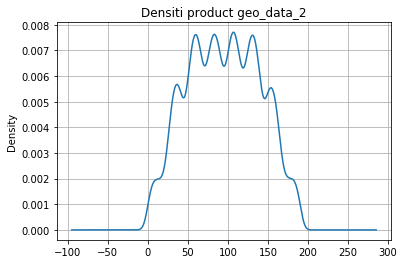

In [28]:
density_3 = geo_data_2['product'].plot(kind = 'density', grid = True, title = 'Densiti product geo_data_2')
plt.show()

# 3. Подготовка к расчёту прибыли

<a id='section10'></a>

По условиям задачи : 

In [47]:
BUDGET = 10000000000   #Бюджет на разработку скважин в регионе 10 млрд. рублей
TOTAL_RECONNAISSANCE = 500 #При разведке исследуют 500 точек
PROFIT_WELLS= 200  # 200 лучших скважин для расчета прибыли
PROFIT_FROM_ONE_BARREL = 450   #Прибыль с одного барреля сырья 450 рублей
PROFIT_FPOM_ONE_PRODUCT = 450000   #Доход с каждой единицы продукта 450 000 рублей

Посчитаем цену за бурение одной скважины

In [48]:
WELL_DRILLING_PRICE = BUDGET / PROFIT_WELLS
WELL_DRILLING_PRICE

50000000.0

Посчитаем Достаточный объем сырья для безубыточной разработки новой скважины

In [52]:
MIN_PRODUCT_MEAN  = WELL_DRILLING_PRICE/PROFIT_FPOM_ONE_PRODUCT
MIN_PRODUCT_MEAN

111.11111111111111

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели. 

In [53]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budget))

Посчитаем прибыль на каждый регион

In [54]:
print('Прибыль первого региона : {:.2f} млрд рублей'.format(revenue(target_df[0], predictions_df[0],200)/10**9))
print('Прибыль второго региона : {:.2f} млрд рублей'.format(revenue(target_df[1], predictions_df[1],200)/10**9))
print('Прибыль третьего региона :{:.2f} млрд рублей'.format(revenue(target_df[2], predictions_df[2],200)/10**9))

Прибыль первого региона : 3.32 млрд рублей
Прибыль второго региона : 2.42 млрд рублей
Прибыль третьего региона :2.71 млрд рублей


## Вывод

Минимальный объем сырья в каждой скважине должен составлять 111 тыс барелей. Наши средние предсказания и средние target трех регионов не проходят минимальный порог

# 4. Расчёт прибыли и рисков 

<a id='section11'></a>

Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для первого региона

In [41]:

import scipy as sp
import scipy.stats

revenues = []

for i in range(1000):
    target_subsample = target_df[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[0][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
final_revenues = []
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 1', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4259385269105923
2.5%-квантиль: -0.10209009483793653
Риск: 6.0
95% доверительный интервал:  (-102090094.83793654, 947976353.358369)


### 4.2 Бутстрап: Регион 2 

<a id='section14'></a>

Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для второго региона

In [58]:
revenues = []

for i in range(1000):
    target_subsample = target_df[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[1][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.5182445035375359
2.5%-квантиль: 0.1281232314330863
Риск: 0.3
Риск: 0.3 %
95% доверительный интервал:  (128123231.43308629, 953612982.0669085)


### 4.3 Бустрап: Регион 3 

<a id='section16'></a>

Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для третьего региона

In [59]:
revenues = []
total_wells = 500
profit_wells = 200

for i in range(1000):
    target_subsample = target_df[2].sample(n=total_wells,replace=True, random_state=state)
    probs_subsample = predictions_df[2][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, profit_wells))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
#interval = interval = st.t.interval(0.95, len(revenues)-1, revenues.mean()/10**9, revenues.sem()/10**9)
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
print("Риск:", (revenues < 0).mean()* 100, '%')
final_revenues.append(('region 3', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4199169307784391
2.5%-квантиль: -0.11585260916001143
95% доверительный интервал:  (-115852609.16001143, 989629939.844574)
Риск: 6.2 %


Выведем все результаты в одной таблице для сравнения.

In [60]:
report_df = pd.DataFrame(final_revenues, columns=['Region', 'Mean Revenue', 'Quantile 2.5%', 'Interval 95%', 'Risks %'])
cm = sns.light_palette("green", as_cmap=True)
s = report_df.style.background_gradient(cmap=cm)
s

,Region,Mean Revenue,Quantile 2.5%,Interval 95%,Risks %
0,region 1,0.425939,-0.10209,"(-102090094.83793654, 947976353.358369)",6
1,region 2,0.518245,0.128123,"(128123231.43308629, 953612982.0669085)",0.3
2,region 3,0.419917,-0.115853,"(-115852609.16001143, 989629939.844574)",6.2


## Вывод

<a id='section17'></a>

Второй регион показывает хорошие результаты. Но так как мы знаем, что второй регион слишком рискованный, слишком странные у него данные - мы не можем его выбрать.

Поэтому для бурения будет лучше выбрать первый регион. Но учитывая оценки прогнозирования, я бы вообще не принимал никаких серьезных решений на основе полученных результатов.

# 5. Общий вывод

<a id='section18'></a>

Если бы у нас не было сведения для сравнения, то рекомендовали бы разработать регион 2 поскольку среднее значение прибыли 104 млрд рублей. На 1 млрд больше чем средное значение прибыли региона 1 и на 2 млрда чем региона 3. Этот результат тоже обосновывается еще на качество метрики модели.

После сравнения полученных результатов с реальными данными следует то, что больше средное значение прибыля получается из региона 2. То есть нецелесообразно  принимать решения на низкие значения метрики коэфициента детерминации.

